In [1]:
import os
import numpy as np 
import damask

In [2]:
%config Completer.use_jedi = False

In [3]:
# some pre-requisites, after `source env/DAMASK.sh`
damask_root = %env DAMASK_ROOT

# 1. create input files (geometery, material, load)

## geometry file

In [4]:
# geometry file (3d periodic grid)
size = np.ones(3)*1e-5
cells = [8,8,8]
N_grains = 4
seeds = damask.seeds.from_random(size,N_grains,cells)
grid = damask.GeomGrid.from_Voronoi_tessellation(cells,size,seeds)
grid.save(f'Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}')
grid

cells:  8 × 8 × 8
size:   1e-05 × 1e-05 × 1e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 4

## material file

In [5]:
# material file has three sections (__homogenization__, __phase__, __material__)
mat = damask.YAML(homogenization={}, phase={}, material={})

In [6]:
hom_single = {
    'SX': {                            # (1) name of homogenization
        'N_constituents': 1,          # (2) components number
        'mechanical': {'type': 'pass'} # (3) type of homogenization
    }
}

mat.update(homogenization=hom_single) # add to material.yaml file

In [7]:
phase_alu = {
    'Aluminium':{                                    # (1) name of your phase
        'lattice': 'cF',                             # (2) lattice specific
        'mechanical': {                              # (3) mechanical properties
            'output': ['F', 'P', 'F_e', 'L_p', 'O'], # Your desired output quantities
            'elastic': {},
            'plastic': {}
        }
    }
}

In [8]:
alu_elast = damask.YAML.load(os.path.join(damask_root,'examples/config/phase/mechanical/elastic/Hooke_Al.yaml'))
alu_plast = damask.YAML.load(os.path.join(damask_root,'examples/config/phase/mechanical/plastic/phenopowerlaw_Al.yaml'))

In [9]:
phase_alu['Aluminium']['mechanical']['elastic']['type'] = alu_elast['type']
phase_alu['Aluminium']['mechanical']['elastic']['C_11'] = alu_elast['C_11']
phase_alu['Aluminium']['mechanical']['elastic']['C_12'] = alu_elast['C_12']
phase_alu['Aluminium']['mechanical']['elastic']['C_44'] = alu_elast['C_44']
phase_alu['Aluminium']['mechanical']['plastic'] = dict(alu_plast)

mat.update(phase=phase_alu) # add to material.yaml file

In [10]:
# material section -> grain orientation, components and etc
## generate a simple random texture and add it to material section
rnd = damask.Rotation.from_random(N_grains)

In [11]:
mat_config = damask.ConfigMaterial(**mat)
mat_config.pop('material') # material_add() requires no 'material' key exsists

{}

In [12]:
# each material is single crystal (homogenization) and alu (phase)
mat_config = mat_config.material_add(O=rnd,phase='Aluminium',homogenization='SX') 
mat_config.save('material.yaml')

## load file

In [13]:
## handy snippet to account for exclusiveness of stress/strain BC
def make_P(F,fill=0):
    return [make_P(i,fill) if isinstance(i,list) else\
            fill if i == 'x' else 'x' for i in F]

In [14]:
# each load file contains (1) solver option, (2) several loadsteps 
load_config = damask.LoadcaseGrid(
    solver={'mechanical':'spectral_basic'}, # (1) solver
    loadstep=[]                             # (2) loadsteps                     
)

In [19]:
# each load step specifies (1) BC (stress or strain), (2) time discretization, (3) output frequency
## load step 1 (tensile in x) ##
dot_F = [[1.e-3, 0 , 0 ],
         [   0 ,'x', 0 ],
         [   0 , 0 ,'x']]

loadstep = {
    'boundary_conditions':{              # (1) BC
        'mechanical':{                
            'dot_F':dot_F,
            'P':make_P(dot_F)
        }
    },
    'discretization':{'t':10.,'N':40},   # (2) time discretization
    'f_out':4                            # (3) output frequency
}

load_config['loadstep'].append(loadstep)

## load step 2 (tensile in x) ##
dot_F = [[1.e-3, 0 , 0 ],
         [   0 ,'x', 0 ],
         [   0 , 0 ,'x']]

loadstep = {
    'boundary_conditions':{              # (1) BC
        'mechanical':{                
            'dot_F':dot_F,
            'P':make_P(dot_F)
        }
    },
    'discretization':{'t':40.,'N':40},   # (2) time discretization
    'f_out':4                            # (3) output frequency
}

load_config['loadstep'].append(loadstep)
load_config.save('load.yaml')

right now you have a similar input file named as 
- `Polycystal_{N_grains}_{cells}.vti`
- `material.yaml`
- `load.yaml`

in your folder now, which resemble the simple example in `DAMASK/examples/grid`


# 2. run simulation with DAMASK-grid solver

In [20]:
fn_vti = f'Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}.vti'
fn_load = 'load.yaml'
fn_material = 'material.yaml'

In [21]:
%%time
run_log = damask.util.run(f'DAMASK_grid -g {fn_vti} -l {fn_load}  -m {fn_material}')

running 'DAMASK_grid -g Polycystal_4_8x8x8.vti -l load.yaml  -m material.yaml' in './'
CPU times: user 90.9 ms, sys: 42.1 ms, total: 133 ms
Wall time: 21.6 s


In [22]:
print(''.join(run_log))


 <<<+-  parallelization init  -+>>>

 Open MPI v4.0.3, package: Debian OpenMPI, ident: 4.0.3, repo rev: v4.0.3, Mar 03, 2020
 MPI standard: 3.1
 OpenMP version: 201511

 MPI processes: 1
 OMP_NUM_THREADS: 4

 <<<+-  CLI init  -+>>>

     _/_/_/      _/_/    _/      _/    _/_/      _/_/_/  _/    _/    _/_/_/
    _/    _/  _/    _/  _/_/  _/_/  _/    _/  _/        _/  _/            _/
   _/    _/  _/_/_/_/  _/  _/  _/  _/_/_/_/    _/_/    _/_/          _/_/
  _/    _/  _/    _/  _/      _/  _/    _/        _/  _/  _/            _/
 _/_/_/    _/    _/  _/      _/  _/    _/  _/_/_/    _/    _/    _/_/_/
 Grid solver

 F. Roters et al., Computational Materials Science 158:420–478, 2019
 https://doi.org/10.1016/j.commatsci.2018.04.030


 Version: 3.0.0-beta-11-g094e18396

 Compiled with: GCC version 12.1.0
 Compiled on: Linux-5.15.0-91-generic
 Compiler options: -cpp -I /home/yi/App/petsc-3.17.3/include -I /home/yi/App/petsc-3.17.3/arch-linux-c-opt/include -I /usr/lib/x86_64-linux-gnu/openm

# 3. process result and visualize

## basic post-processing

In [31]:
result_hdf = '_'.join((fn_vti.split('.')[0], fn_load.split('.')[0], fn_material.split('.')[0]))+'.hdf5'
result = damask.Result(result_hdf)
result

Created by DAMASK_grid 3.0.0-beta-11-g094e18396
        on 2024-02-01 21:26:56+0100
 executing "DAMASK_grid -g Polycystal_4_8x8x8.vti -l load.yaml -m material.yaml"

increment_0 (0.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1 q_2 q_3)
        P / Pa: first Piola-Kirchhoff stress
        gamma_sl / 1: plastic shear
        xi_sl / Pa: resistance against plastic slip
  homogenization
    SX
      mechanical

increment_4
  ...

increment_8
  ...

increment_12
  ...

increment_16
  ...

increment_20
  ...

increment_24
  ...

increment_28
  ...

increment_32
  ...

increment_36
  ...

increment_40
  ...

increment_44
  ...

increment_48
  ...

increment_52
  ...

increment_56
  ...

increment_60
  ...

increment_64
  ...

increment_68
  ...

increment_72
  ...

increment_76
  ...

increment_80
  ...

incremen

In [ ]:
# post-processing: (1) add variables, (2) view certain increments, (3) export for paraview
## (1) can act only on certain increments! when you have too large data
result.add_stress_Cauchy()                      # Cauchy stress
result.add_strain()                             # ln(V)    
result.add_equivalent_Mises('sigma')            # von Mises value maybe more representative
result.add_equivalent_Mises('epsilon_V^0.0(F)') # von Mises like strain based on ln(V) 

In [ ]:
## (2) various ways to view
result.view(times=result.times_in_range(5,35))
result.view(increments=-1)

In [48]:
## (3) various export options
result.export_VTK()
result.export_simulation_setup(target_dir='sim_setup')

## customized analysis

In [35]:
import pandas as pd
import seaborn as sns

In [43]:
grains = [0,1,3]
grid   = damask.GeomGrid.load(fn_vti) # get back my grid
# loop over all increments and store P(1,1) per grain and avg(F(1,1))
data = {g:pd.DataFrame() for g in grains}
for inc in result.get(['F','P']).values():
    P = inc['P']
    F = inc['F']
    for g in grains:
        points = grid.material.flatten(order='F')==g
        P_11 = P[points,0,0].flatten()
        F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
        x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
        data[g] = pd.concat((data[g],x),ignore_index=True)

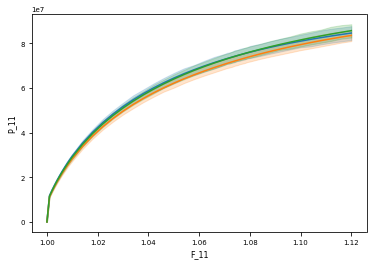

In [44]:
for g in grains:
   plot = sns.lineplot(y='P_11',x='F_11',data=data[g])

fig = plot.get_figure()

## some in-line visualization with pyvista

need to `pip install pyvista` and `pip install 'jupyterlab>=3' ipywidgets 'pyvista[all,trame]'`

In [1]:
import pyvista as pv
# pv.set_jupyter_backend('trame')

In [2]:
pv.set_jupyter_backend?

In [3]:
pv.set_jupyter_backend('trame')

ValueError: Invalid Jupyter notebook plotting backend "trame".
Use one of the following:
"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "none"